# <center> Соревнование на Kaggle

Задание:   
необходимо воспользоваться опытом предыдущих недель и побить бейзлайн в соревновании по сентимент-анализу отзывов на товары на Kaggle Inclass:

https://inclass.kaggle.com/c/product-reviews-sentiment-analysis-light

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import numpy as np
import pandas as pd
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
import xgboost as xgb

%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re

In [3]:
# функция для записи submission  в папку data
def write_submission(filename, pred):
    pd.DataFrame(pred, columns=['y']).to_csv(path_or_buf='data/' + filename, index_label='Id')

In [4]:
train = pd.read_csv('data/products_sentiment_train.tsv', sep='\t', header=None, names=['text', 'target'])

In [15]:
train.head()

,text,target
0,"2 . take around 10,000 640x480 pictures .",1
1,i downloaded a trial version of computer assoc...,1
2,the wrt54g plus the hga7t is a perfect solutio...,1
3,i dont especially like how music files are uns...,0
4,i was using the cheapie pail ... and it worked...,1


In [5]:
test = pd.read_csv('data/products_sentiment_test.tsv', sep='\t', header=0, names=['text'])

In [19]:
test.head()

,text
0,"so , why the small digital elph , rather than ..."
1,3/4 way through the first disk we played on it...
2,better for the zen micro is outlook compatibil...
3,6 . play gameboy color games on it with goboy .
4,"likewise , i 've heard norton 2004 professiona..."


Выпишем итоги предыдущих недель, когда мы настраивали параметры:
1. **vectorizer**: CountVectorizer() / TfidfVectorizer(): 0.841 / 0.821 --> **CountVectorizer()**
2. **min_df** у CountVectorizer: 1 (default) / 10 / 50: 0.841/0.839/0.813 --> **1 (default)**
3. **классификатор**: LogisticRegression / LinearSVC / SGDClassifier: 0.841 / 0.833 / 0.784 --> **LogisticRegression**
4. **стоп-слова**: nltk.corpus.stopwords.words('english') / 'english': 0.8415 / 0,839 --> **nltk.corpus.stopwords.words('english')**
5. **ngramm**: (1, 2), analyzer='word' (default) / (3, 5), analyzer='char_wb': 0.853 / 0.82 --> **(1, 2), analyzer='word'** (default)

Сделаем предсказание с учетом этих параметров и отошлем на **Kaggle**

In [24]:
%%time
CountVect = CountVectorizer(stop_words=stopwords.words('english'), ngram_range=(1, 2))
logit = LogisticRegression()
CountVect_logit = Pipeline([('CountVect', CountVect), ('logit', logit)])
pred = CountVect_logit.fit(train['text'], train['target']).predict(test['text'])

Wall time: 843 ms


In [33]:
write_submission('submiss_param_week12.csv', pred)

**Kaggle:** 0.77749    
Ок, отправная точка ясна )   

Будем подбирать параметры

Для начала посмотрим, чему равна **accuracy** на **кросс-валидации** при выбранных выше параметрах

In [83]:
%%time
CountVect = CountVectorizer(stop_words=stopwords.words('english'), ngram_range=(1, 2))
logit = LogisticRegression()
CountVect_logit = Pipeline([('CountVect', CountVect), ('logit', logit)])
cv_acc_score = cross_val_score(CountVect_logit, train['text'], train['target'], cv=5).mean()
print('cv_acc_score =', cv_acc_score)

cv_acc_score = 0.748498134363
Wall time: 825 ms


Попробуем **ngram_range=(1, 3)**:

In [84]:
%%time
CountVect = CountVectorizer(stop_words=stopwords.words('english'), ngram_range=(1, 3))
logit = LogisticRegression()
CountVect_logit = Pipeline([('CountVect', CountVect), ('logit', logit)])
cv_acc_score = cross_val_score(CountVect_logit, train['text'], train['target'], cv=5).mean()
print('cv_acc_score =', cv_acc_score)

cv_acc_score = 0.747495634348
Wall time: 1.22 s


Эффекта нет

Попробуем подбор параметров с помощью **hyperopt** (хотя здесь, наверное, и **GreadSearch** хватило бы)

In [41]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [112]:
%%time

# задаем предобработку и классификатор
CountVect = CountVectorizer(stop_words=stopwords.words('english'), ngram_range=(1, 2))
logit = LogisticRegression()
CountVect_logit = Pipeline([('CountVect', CountVect), ('logit', logit)])

# задаем функцию для опримизации
def hyperopt_objective(params):
    cv_acc_score = cross_val_score(CountVect_logit.set_params(logit__C=params['C']), train['text'], train['target'], cv=5).mean()
    
    return {'loss': - cv_acc_score, 'status': STATUS_OK}

# задаем диапазоны подбора параметров
params_space = {
    'C': hp.loguniform('C', -4, 4), # default = 1.0
                }

# запускаем подбор
trials = Trials()

best_params = fmin(
    hyperopt_objective,
    space=params_space,
    algo=tpe.suggest,
    max_evals=50,
    trials=trials
)

accuracy_hyp = - trials.best_trial['result']['loss']
print(best_params, 'accuracy_hyp =', accuracy_hyp)

{'C': 0.425966259859712} accuracy_hyp = 0.7524943937149609
Wall time: 44 s


**accuracy** немного улучшилась. Применим полученные параметры и сделаем посылку на **Kaggle**:

In [113]:
%%time
CountVect = CountVectorizer(stop_words=stopwords.words('english'), ngram_range=(1, 2))
logit = LogisticRegression()
CountVect_logit = Pipeline([('CountVect', CountVect), ('logit', logit)])
pred = CountVect_logit.set_params(logit__C=best_params['C']).fit(train['text'], train['target']).predict(test['text'])
write_submission('submiss_C_hyper.csv', pred)

Wall time: 201 ms


**Kaggle:** 0.77750    
Особого улучшения пока нет

Пробуем **TfidfVectorizer** с **analyzer='char', ngram_range=(3, 7)** и подбираем параметры через **GridSearchCV**

In [223]:
%%time

# задаем предобработку и классификатор
vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'), analyzer='char', ngram_range=(3, 7))
X_train = vectorizer.fit_transform(train['text'])
y_train = train['target']
clf = LogisticRegression()

param_grid = {
              'C': np.linspace(0.01, 10, 100)             
             }

gridsearch = GridSearchCV(clf, param_grid, scoring='accuracy')
gridsearch.fit(X_train, y_train)

print(gridsearch.best_params_, 'best accuracy =', gridsearch.best_score_)

{'C': 8.8899999999999988} best accuracy = 0.7755
Wall time: 1min 13s


In [224]:
%%time
X_test = vectorizer.transform(test['text'])
pred = gridsearch.best_estimator_.predict(X_test)
write_submission('submiss_Tfidf_LR_C.csv', pred)

Wall time: 357 ms


**Kaggle:** 0.80500   
ну вот и хорошо, **Simple benchmark** прошли!

Посмотрим балансировку классов:

In [6]:
train['target'].value_counts()

1    1274
0     726
Name: target, dtype: int64

Подберем параметры более аккуратно, учтя при этом **балансировку** классов:

In [7]:
%%time

# задаем предобработку и классификатор
vectorizer = CountVectorizer(stop_words=stopwords.words('english'), analyzer='char', ngram_range=(3, 10))
X_train = vectorizer.fit_transform(train['text'])
y_train = train['target']
clf = LogisticRegression(class_weight='balanced', random_state=17)

param_grid = {
              'C': np.logspace(-4, 3, 100)             
             }

gridsearch = GridSearchCV(clf, param_grid, scoring='accuracy', n_jobs=-1)
gridsearch.fit(X_train, y_train)

print(gridsearch.best_params_, 'best accuracy =', gridsearch.best_score_)

{'C': 0.0025950242113997372} best accuracy = 0.791
Wall time: 7min 39s


Что еще можно сделать:
- xgboost
- предобработка текста

In [9]:
vectorizer = CountVectorizer(stop_words=stopwords.words('english'), analyzer='char', ngram_range=(3, 10))
transformer = TfidfTransformer()
clf = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, n_iter=5, random_state=17)
text_clf = Pipeline([('vectorizer', vectorizer),
                     ('transformer', transformer),
                     ('clf', clf)])

accuracy_text = cross_val_score(text_clf, train['text'], train['target'], cv=5).mean()
print('accuracy_text =', accuracy_text)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:117: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochast

accuracy_text = 0.744995609348


Сделаем посылку с полученным **последним наилучшим результатом:    
{'C': 0.0025950242113997372} best accuracy = 0.791**

In [11]:
%%time
vectorizer = CountVectorizer(stop_words=stopwords.words('english'), analyzer='char', ngram_range=(3, 10))
X_train = vectorizer.fit_transform(train['text'])
X_test = vectorizer.transform(test['text'])
y_train = train['target']
clf = LogisticRegression(class_weight='balanced', C=0.093260334688321997, random_state=17)

pred = clf.fit(X_train, y_train).predict(X_test)
write_submission('submiss_LR_C093_bal_corr.csv', pred)

Wall time: 7.79 s


Крайний вариант дал **Kaggle: 0.82250**   

**Краткий анализ того, что получилось.**  
Максимальный результат на сегодня получился при подборе 'С' без баланса, но при посылке на Kaggle при этом баланс **учитывали**. 

Этому предшествовали:    
подбор на "балансе" дал `cv_score` **выше** подбора без баланса (**0.791** против **0.784**), но результат на Kaggle при этом получился **хуже** (**0.80750** против **0.81000**). А такая вот "перекрестная" посылка оказалась лучше! Вот такой неожиданный вывод.

## Поработаем с предобработкой текста

Для этого импортируем пакет для **стемминга**, то есть приведения всех слов к стандартному виду

In [17]:
from nltk.stem import SnowballStemmer
print(" ".join(SnowballStemmer.languages))

danish dutch english finnish french german hungarian italian norwegian porter portuguese romanian russian spanish swedish


In [34]:
# пробуем
stemmer_ru = SnowballStemmer('russian')
print(stemmer_ru.stem('Сделаем посылку с^ : полученным последним наилучшим результатом'))

сделаем посылку с^ : полученным последним наилучшим результат


In [38]:
%%time

# задаем предобработку и классификатор
vectorizer = CountVectorizer(stop_words=stopwords.words('english'), analyzer='char', ngram_range=(3, 10))
stemmer = SnowballStemmer('english') # создаем класс для приведения слов к стандартному виду
X_train = vectorizer.fit_transform(train['text'].apply(lambda s: stemmer.stem(s)))
y_train = train['target']
clf = LogisticRegression(random_state=17)

param_grid = {
              'C': np.logspace(-4, 3, 100)             
             }

gridsearch = GridSearchCV(clf, param_grid, scoring='accuracy', n_jobs=-1)
gridsearch.fit(X_train, y_train)

print(gridsearch.best_params_, 'best accuracy =', gridsearch.best_score_)

{'C': 0.035111917342151307} best accuracy = 0.7835
Wall time: 6min 9s


Да..., пока стемминг улучшений не внес...

Попробуем убрать знаки препинания (некоторые, не все:   
**)(!?** - оставляем, они могут тоже выражать настроение)

In [102]:
import re
# тестируем
train['text'].head(2).apply(lambda s: re.sub(r'[0-9.,:/)(#\']', ' ', s))
# train['text'].head(2).apply(lambda s: re.sub('\w', '', s))

0                take around           x    pictures  
1    i downloaded a trial version of computer assoc...
Name: text, dtype: object

In [91]:
%%time

# задаем предобработку и классификатор
vectorizer = CountVectorizer(stop_words=stopwords.words('english'), analyzer='char', ngram_range=(3, 10))
stemmer = SnowballStemmer('english') # создаем класс для приведения слов к стандартному виду
X_train = vectorizer.fit_transform(train['text'].apply(lambda s: stemmer.stem(re.sub(r'[.,:/#\']', '', s))))
y_train = train['target']
clf = LogisticRegression(random_state=17)

param_grid = {
              'C': np.logspace(-4, 3, 100)             
             }

gridsearch = GridSearchCV(clf, param_grid, scoring='accuracy', n_jobs=-1)
gridsearch.fit(X_train, y_train)

print(gridsearch.best_params_, 'best accuracy =', gridsearch.best_score_)

{'C': 0.048626015800653531} best accuracy = 0.7825
Wall time: 6min 15s


## Поработаем с XGBoost

In [98]:
%%time
# задаем предобработку и классификатор
vectorizer = CountVectorizer(stop_words=stopwords.words('english'), analyzer='char', ngram_range=(3, 10))
X_train = vectorizer.fit_transform(train['text'])
y_train = train['target']
clf = xgb.XGBClassifier(random_state=17)

accuracy_text = cross_val_score(clf, X_train, y_train).mean()
print('accuracy_text =', accuracy_text)

accuracy_text = 0.73001037019
Wall time: 3min 58s


На дефолтных параметрах результат невысокий и считается достаточно долго ==> подбор будет тоже долгий. Пока оставим как есть.   
**Итого:**   
максимальный результат на **Kaggle - 0.82250** (это скорректированный, изначально был 0.81000)    
Скриншот соревнования на **Kaggle:** https://prnt.sc/ie5baj

## Попробуем НАИВНЫЙ БАЙЕС

In [12]:
from sklearn.naive_bayes import MultinomialNB

In [17]:
%%time
# задаем предобработку и классификатор
vectorizer = CountVectorizer(stop_words=stopwords.words('english'), analyzer='char', ngram_range=(3, 10))
X_train = vectorizer.fit_transform(train['text'])
y_train = train['target']
clf = MultinomialNB(fit_prior=True)

accuracy_text = cross_val_score(clf, X_train, y_train).mean()
print('accuracy_text =', accuracy_text)

accuracy_text = 0.792497895197
Wall time: 5.74 s


То же, с **предобработкой текста**

In [103]:
%%time
# задаем предобработку и классификатор
vectorizer = CountVectorizer(stop_words=stopwords.words('english'), analyzer='char', ngram_range=(3, 10))
stemmer = SnowballStemmer('english') # создаем класс для приведения слов к стандартному виду
X_train = vectorizer.fit_transform(train['text'].apply(lambda s: stemmer.stem(re.sub(r'[.,:/#\'%@$^&*-+<>]', ' ', s))))
y_train = train['target']
clf = MultinomialNB(fit_prior=True)

accuracy_text = cross_val_score(clf, X_train, y_train).mean()
print('accuracy_text =', accuracy_text)

accuracy_text = 0.79149614382
Wall time: 5.9 s


Не улучшился

**Вспомогательная функция для отрисовки кривых валидации после запуска GridSearchCV (или RandomizedCV)**

In [18]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

In [42]:
%%time

# задаем предобработку и классификатор
vectorizer = CountVectorizer(stop_words=stopwords.words('english'), analyzer='char', ngram_range=(3, 10))
# stemmer = SnowballStemmer('english') # создаем класс для приведения слов к стандартному виду
# X_train = vectorizer.fit_transform(train['text'].apply(lambda s: stemmer.stem(re.sub(r'[.,:/#\']', '', s))))
X_train = vectorizer.fit_transform(train['text'])
y_train = train['target']
clf = MultinomialNB()

param_grid = {
              'alpha': np.linspace(1e-10, 2, 30)             
             }

gridsearch = GridSearchCV(clf, param_grid, scoring='accuracy', return_train_score = True)
gridsearch.fit(X_train, y_train)

print(gridsearch.best_params_, 'best accuracy =', gridsearch.best_score_)

{'alpha': 0.96551724143103457} best accuracy = 0.792
Wall time: 22.9 s


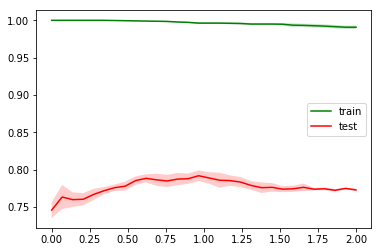

In [43]:
plot_validation_curves(param_grid['alpha'], gridsearch.cv_results_)

**Вывод по Наивному Байесу:**    
Результат выше, чем у других классификаторов, наилучшее значение - при дефолтных параметрах.    
Делаем посылку на Kaggle

In [37]:
%%time
vectorizer = CountVectorizer(stop_words=stopwords.words('english'), analyzer='char', ngram_range=(3, 10))
X_train = vectorizer.fit_transform(train['text'])
X_test = vectorizer.transform(test['text'])
y_train = train['target']
clf = MultinomialNB()

pred = clf.fit(X_train, y_train).predict(X_test)
write_submission('submiss_NB_def.csv', pred)

Wall time: 6.07 s


**Kaggle:** 0.78250

#### потестируем замену в регулярных выражениях

In [134]:
re.sub(re.compile(r'http|[/:?.,_=]'), ' ', 'http://snakeproject.ru/rubric/article.php?art=python_reg_exp')

'    snakeproject ru rubric article php art python reg exp'

здесь:    
"|" в compile означает "или": или то, что слева (то есть http), или то что справа (то есть любой из символов в квадратных скобках)

In [135]:
print(r'1\n2') # префикс r - сырые данные (то есть "как есть", не учитывая метасимволы)

1\n2


In [3]:
print('1\n2')

1
2


In [18]:
a = None # в ифе - как Фальш
if a:
    print(True)
else:
    print(False)

False
